# 2 - Machine Learning for Finance

<br>

## Questions to address:
 - Perform EDA to understand the financial data to be analysed
 - Perform Feature Engeneering
 - Predict 5 day future percentage return using different models

<br>

## Tools:
 - Create moving averages and rsi 
 - Dummy coding for day of the week
 - LinearRegressor, RandomForestRegressor, GradientBoostingRegressor, KNN
 - feature importance
 - Neural Networks with custom loss function, dropout and ensembling

<br>

### load defaults

In [1]:
import pandas as pd
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

plt.style.use('seaborn')
plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))

#Project specific
import tensorflow as tf
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
import keras.losses

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
import statsmodels.api as sm

print("Defaults Loaded")

Using TensorFlow backend.


Defaults Loaded


<br>

## 1 - EDA (exploratory data analysis)
- we can predict raw prices of stocks, but tipically will predict percent changes (easier to interpret results)

In [2]:
df = pd.read_csv('./data/AAPL.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index(['Date'],inplace=True)
lng_df = df[['Adj_Close','Adj_Volume']].loc['2016-04-15':]
display(lng_df[:3])

df = pd.read_csv('./data/SPY.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index(['Date'],inplace=True)
spy_df = df[['Adj_Close','Adj_Volume']].loc['2016-04-15':]
display(spy_df[:3])

,Adj_Close,Adj_Volume
Date,,
2016-04-15,106.319406,46938969.0
2016-04-18,104.025578,60821461.0
2016-04-19,103.473898,32384879.0


,Adj_Close,Adj_Volume
Date,,
2016-04-15,199.760673,75761600.0
2016-04-18,201.164330,75277700.0
2016-04-19,201.798846,88316100.0


plot the evolution of the value for the two stocks

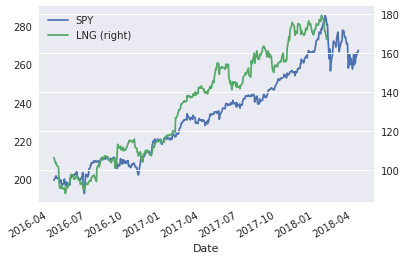

In [3]:
spy_df['Adj_Close'].plot(label='SPY', legend=True)
lng_df['Adj_Close'].plot(label='LNG', legend=True, secondary_y=True)
plt.show()  # show the plot

Histogram of the daily price change, in percentage, for LNG

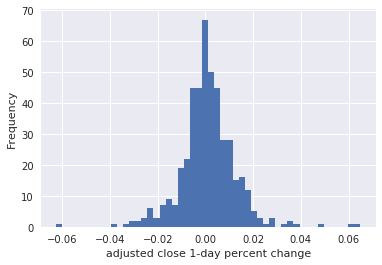

In [4]:
lng_df['Adj_Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

Look at correlations in value of stock for different timesacles:
- corr uses pearson correlation by default which assumes normal distributions and measures linear correlations

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000             0.076956
5d_close_future_pct      0.076956             1.000000


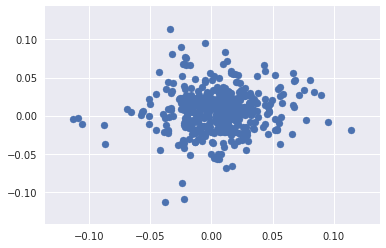

In [5]:
#data for 5 days in the future
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)

# 5-day percentage changes of Adj_Close for the current day, and 5 days in the future
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(lng_df['5d_close_pct'], lng_df['5d_close_future_pct'])
plt.show()

there is some correlation between current value and 10 days in future, but that is just because prices dont vary that much in 10 days

<br>

## 2 - Feature Engeneering

<br>

**Create moving averages and rsi** for timeperiods of 14, 30, 50, and 200 
  - Relative Strength Index: $RSI=100-\frac{100}{1+RS}$, where $RS=\frac{\mathrm{Avg\;GAIN\;over\;n\;periods}}{\mathrm{Avg\;LOSS\;over\;n\;periods}}$

In [6]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Get the difference in price from previous step
delta = lng_df['Adj_Close'].diff()
# Get rid of the first row, which is NaN since it did not have a previous 
delta = delta[1:] 

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14,30,50,200]:

    # Create the moving average indicator and divide by Adj_Close
    lng_df['ma' + str(n)] = lng_df['Adj_Close'].rolling(window=n, center=False).mean().shift(0)/ lng_df['Adj_Close']
    
    # Create the RSI indicator
    window_length=n
   
    # Calculate the SMA
    roll_up2 = up.rolling(window=n, center=False).mean().shift(0)
    roll_down2 = down.abs().rolling(window=n, center=False).mean().shift(0)

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))

    # Create the RSI indicator
    lng_df['rsi' + str(n)] = RSI2
      
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


<br>

**Create 2 new volume features**, 1-day % change and 5-day SMA of the % change

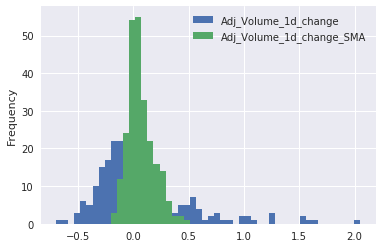

In [20]:
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
#1-day % change
lng_df['Adj_Volume_1d_change'] = lng_df['Adj_Volume'].pct_change()
#moving averge
lng_df['Adj_Volume_1d_change_SMA'] = lng_df['Adj_Volume_1d_change'].rolling(window=5, center=False).mean().shift(0)

# Plot histogram of volume % change data
lng_df[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

<br>

**Dummy Coding day of the week** (remove the first since one colums is always redundant)

In [21]:
days_of_week = pd.get_dummies(lng_df.index.dayofweek, prefix='weekday', drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe
lng_df = pd.concat([lng_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place
print("dummies coded")

dummies coded


In [22]:
display(lng_df.iloc[:3,-9:])

,rsi50,ma200,rsi200,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA,weekday_1,weekday_2,weekday_3,weekday_4
Date,,,,,,,,,
2017-02-07,78.054174,0.815827,57.578251,0.422333,0.164370,1,0,0,0
2017-02-08,78.023803,0.813763,57.883843,-0.397544,-0.170353,0,1,0,0
2017-02-09,79.055887,0.809091,58.331497,0.232384,0.015919,0,0,1,0


create targets and feature df

In [23]:
# Drop all na values
lng_df = lng_df.dropna()

# Create features and targets
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feat_targ_df = lng_df[['5d_close_future_pct'] + feature_names]

<br>

**Investigate quality of newly create features with corr and heat map**

5d_close_future_pct         1.000000
5d_close_pct                0.002554
ma14                        0.004240
rsi14                      -0.002983
ma30                        0.033583
rsi30                      -0.077678
ma50                        0.134753
rsi50                      -0.070214
ma200                       0.144396
rsi200                     -0.096554
Adj_Volume_1d_change        0.045435
Adj_Volume_1d_change_SMA    0.071048
weekday_1                  -0.011640
weekday_2                   0.002626
weekday_3                   0.003721
weekday_4                   0.012475
Name: 5d_close_future_pct, dtype: float64


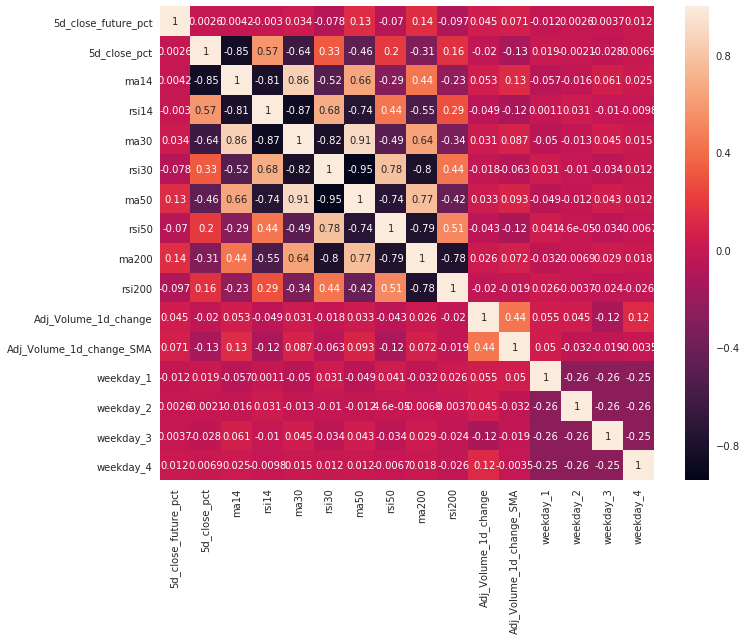

In [29]:
corr = feat_targ_df.corr()
print(corr['5d_close_future_pct'])

fig, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

some features appear week but they might help when combined to additional information)

**create train and test samples**

In [75]:
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

print(f"full sample size: {linear_features.shape[0]}")
print(f"train size: {train_features.shape[0]}")
print(f"test size: {test_features.shape[0]}")

full sample size: 244
train size: 207
test size: 37


<br>

## 3 - Linear Model

add intercept to df and do train test split

In [69]:
# Add a constant to the features
linear_features = sm.add_constant(features)
linear_train_features = linear_features[:train_size]
linear_test_features = linear_features[train_size:]

In [70]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, linear_train_features)
results = model.fit()  # fit the model
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.312
Model:                             OLS   Adj. R-squared:                  0.258
Method:                  Least Squares   F-statistic:                     5.786
Date:                 Mon, 25 Feb 2019   Prob (F-statistic):           8.98e-10
Time:                         17:11:08   Log-Likelihood:                 512.00
No. Observations:                  207   AIC:                            -992.0
Df Residuals:                      191   BIC:                            -938.7
Df Model:                           15                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const         

**examine pvalues** (Features with p <= 0.05 are typically considered significantly different from 0)

In [71]:
print(results.pvalues[results.pvalues.values<0.05])

const    9.232416e-03
ma30     3.243623e-07
rsi30    3.599328e-03
ma50     1.676311e-12
rsi50    1.370074e-05
dtype: float64


**make predictions and plot predictions vs the targets**

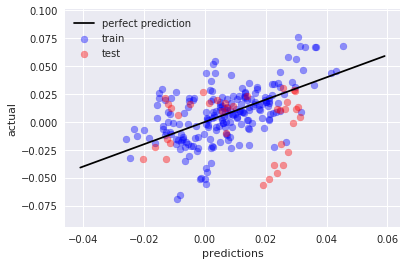

In [72]:
train_predictions = results.predict(linear_train_features)
test_predictions = results.predict(linear_test_features)

plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect prediction')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

<br>

## 4 - RandomForestRegressor with ParameterGrid hyperparameter search

In [61]:
#grid of hyperparameters
grid = {'n_estimators':[200], 'max_depth': [3, 5, 10], 'max_features': [4,8,15], 'random_state': [42]}
test_scores = []

rfr = RandomForestRegressor()
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    #default scoring is R^2
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(f"R^2: {test_scores[best_idx]:0.3f}\n", ParameterGrid(grid)[best_idx])

R^2: -0.457
 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


**make predictions and plot predictions vs the targets** from best random forest model

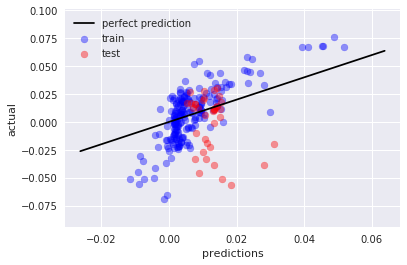

In [62]:
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect prediction')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

<br>

**feature importance**

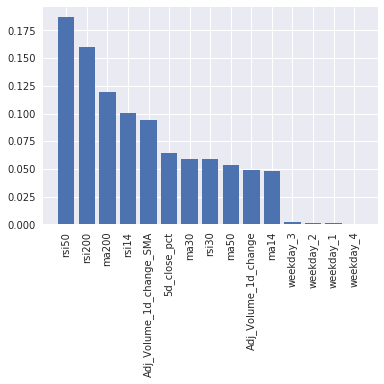

In [63]:
importances = rfr.feature_importances_

#sort importances then reverse
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

<br>

## 5 - Gradient Boosting Regressor

In [76]:
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(f"Train R^2: {gbr.score(train_features, train_targets):0.3f}")
print(f"Test R^2: {gbr.score(test_features, test_targets):0.3f}")

Train R^2: 0.557
Test R^2: -0.404


**feature importance**

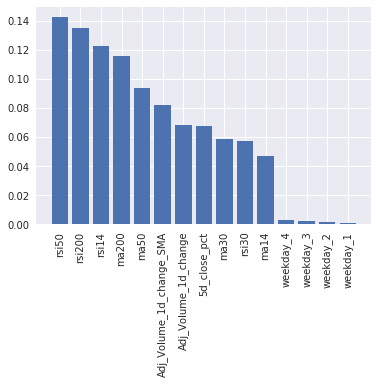

In [77]:
feature_importances = gbr.feature_importances_
sorted_index = np.argsort(feature_importances)[::-1]
x = range(features.shape[1])

labels = np.array(feature_names)[sorted_index]
plt.bar(x, feature_importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

## 6 - Standardize data (KNN and neural nets work better)

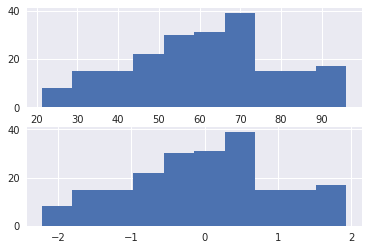

In [78]:
# Remove unimportant features (weekdays)
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

<br>

## 7 - KNN Regressor

In [80]:
for n in range(2,13,2):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)    
    train_score = knn.score(scaled_train_features, train_targets)
    test_score = knn.score(scaled_test_features, test_targets)
    print(f'train / test scores: {train_score:0.4f} / {test_score:0.4f}')    
    print()  # prints a blank line

n_neighbors = 2
train / test scores: 0.8894 / -0.5522

n_neighbors = 4
train / test scores: 0.6824 / -0.4101

n_neighbors = 6
train / test scores: 0.5626 / -0.3107

n_neighbors = 8
train / test scores: 0.4726 / -0.1490

n_neighbors = 10
train / test scores: 0.4054 / -0.1052

n_neighbors = 12
train / test scores: 0.3898 / -0.0365



**make predictions and plot predictions vs the targets**

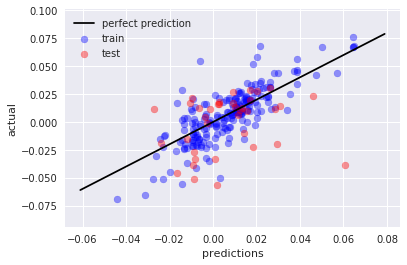

In [81]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)


plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect prediction')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

<br>

## 8 - Neural Nets
- capture non-linearity, capture variable interaction and highly customizable
- ReLU activation: rectified linear units (zero for negative, linear for positive numbers)
- loss functions to compare predictions and targets (usually MSE for regression)
- backpropagation, pass the error function back through the neural network to improve it

**create and fit NN**

In [82]:
# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=100, verbose=0)

print('model fit completed')

model fit completed


**examine loss**

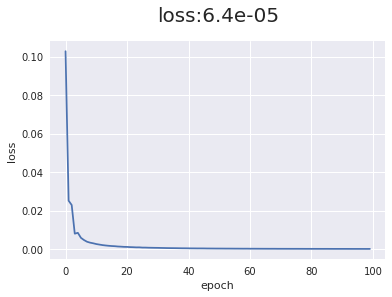

In [83]:
loss = history.history['loss']
plt.plot(np.array(loss))
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

**Evaluate performance**

R^2 train 0.911
R^2 test -10.447


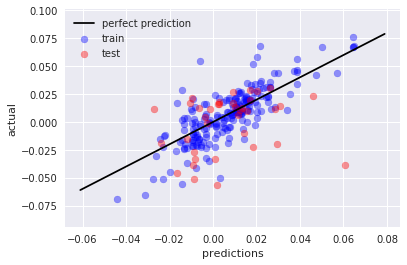

In [86]:
# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(f"R^2 train {r2_score(train_targets, train_preds):0.3f}")
print(f"R^2 test {r2_score(test_targets, test_preds):0.3f}")

plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect prediction')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

<br>

## 9 - Neural Net with Custom Loss function using keras
penalty when predictions has opposite sign with respect to target (MSE with directional penalty):
  - $\sum(y-\hat{y})^2$, if directions match
  - $\sum(y-\hat{y})^2\times\mathrm{penalty}$, if directions do not match

**Define loss function and activate with keras**

In [87]:
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1) # train on last axis, the one our NN was just trained on

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x1c35b69598>


**train model**

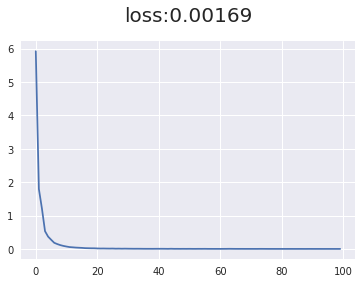

In [88]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=100, verbose=0)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

**Evaluate performance**

R^2 train -1.577
R^2 test -30.802


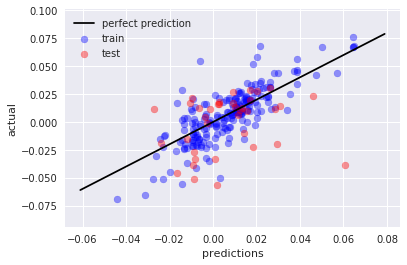

In [89]:
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(f"R^2 train {r2_score(train_targets, train_preds):0.3f}")
print(f"R^2 test {r2_score(test_targets, test_preds):0.3f}")

plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect prediction')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

<br>

## 10 - Combat NN overfiting with dropout
other methods to combat overfitting:
  - Decrease number of nodes, L1/L2 regulariation, dropout, Autoencoder architecture, Early stopping, Adding noise to data, Max norm constraints, Ensembling

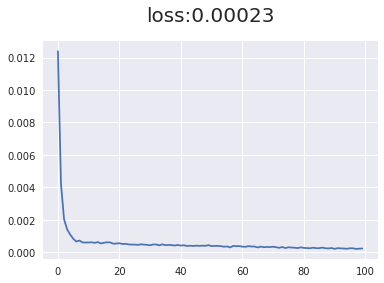

In [92]:
# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(500, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.4))
model_3.add(Dense(100, activation='relu'))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=100, verbose=0)

#plot loss
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

**Evaluate performance**

R^2 train 0.741
R^2 test -1.270


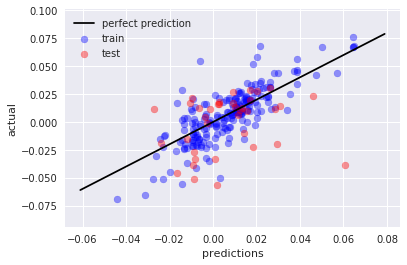

In [94]:
train_preds = model_3.predict(scaled_train_features)
test_preds = model_3.predict(scaled_test_features)
print(f"R^2 train {r2_score(train_targets, train_preds):0.3f}")
print(f"R^2 test {r2_score(test_targets, test_preds):0.3f}")

plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect prediction')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

<br>

## 11 - Combat NN overfiting with Ensembling (averaging the 3 models)

In [95]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
print(test_preds[-5:])

[0.03809962 0.08305165 0.00658729 0.08424643 0.16536923]


**Evaluate performance**

R^2 train 0.682
R^2 test -6.148


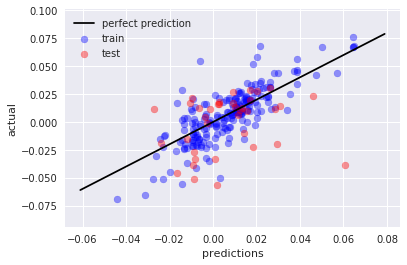

In [96]:
print(f"R^2 train {r2_score(train_targets, train_preds):0.3f}")
print(f"R^2 test {r2_score(test_targets, test_preds):0.3f}")

plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect prediction')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()